# Visualising Lyapunov Exponent for the 2D Standing Map in JAX

In [2]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product


plt.style.use("ggplot")

In [ ]:
@jax.vmap
def plot_mod(x):
    return jnp.array(
        [x[0] % 1, jax.lax.cond(x[1] % 1 <= 0.5, lambda x_1: x_1 % 1, lambda x_1: x_1 % -1, x[1])]
    )

def plot_2d_trajectory(trajectory):
    mod_trajectory = plot_mod(trajectory)
    plt.scatter(mod_trajectory[:, 0], mod_trajectory[:, 1])
    plt.show()

def plot_2d_trajectories(trajectories):
    for trajectory in trajectories:
        mod_trajectory = plot_mod(trajectory)
        plt.scatter(mod_trajectory[:, 0], mod_trajectory[:, 1], c="blue")
    plt.show()

In [4]:
class _2DMapStepper:
    def __init__(self, K):
        self.K = K

    def __call__(self, coords, _):
        next_coords = jnp.array([
            coords[0] + coords[1] + self.K / (2 * jnp.pi) * jnp.sin(2 * jnp.pi * coords[0]),
            coords[1] + self.K / (2 * jnp.pi) * jnp.sin(2 * jnp.pi * coords[0]),
        ])
        return next_coords, next_coords
    
def rollout(stepper, init_coords, length):
    _, trajectory = jax.lax.scan(stepper, init_coords, None, length)
    return trajectory

In [5]:
K = 0.6
length = 10_000

x_1 = jnp.linspace(0.01, 0.99, 12)
x_2 = jnp.linspace(-0.51, 0.49, 12)

init_coords = jnp.array(list(product(x_1, x_2)))
stepper = _2DMapStepper(K)
vec_rollout = jax.vmap(rollout, in_axes=[None, 0, None])

trajectories = vec_rollout(stepper, init_coords, length)

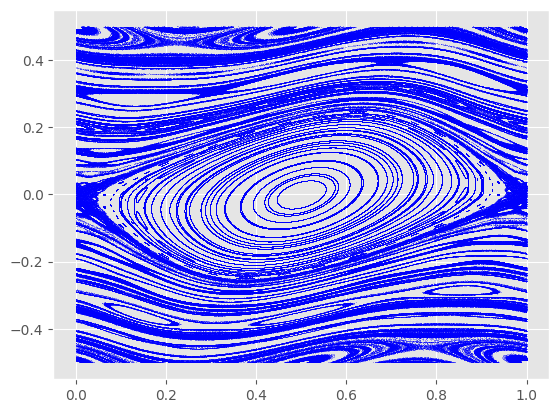

In [6]:
plot_2d_trajectories(trajectories)

In [7]:
class _2DMapStepperGrowth:
    def __init__(self, K=0.6):
        self.K = K

    def __call__(self, coords, deviation):
        next_coords = jnp.array(
            [
                coords[0]
                + coords[1]
                + self.K / (2 * jnp.pi) * jnp.sin(2 * jnp.pi * coords[0]),
                coords[1] + self.K / (2 * jnp.pi) * jnp.sin(2 * jnp.pi * coords[0])
            ]
        )

        next_deviation = jnp.array(
            [
                deviation[0] * (1 + self.K * jnp.cos(2 * jnp.pi * coords[0]))
                + coords[3],
                deviation[0] * (self.K * jnp.cos(2 * jnp.pi * coords[0]))
                + deviation[1],
            ]
        )
        return next_coords, next_deviation


def rollout(stepper, length):

    def scan_transformation(carry, _):
        coords, deviation = carry
        next_coords, unnormalised_next_deviation = stepper(coords, deviation)

        growth = jnp.linalg.norm(unnormalised_next_deviation)

        next_deviation = unnormalised_next_deviation / growth

        next_carry = (next_coords, next_deviation)

        return next_carry, (next_coords, growth)
    
    def rollout_transformation(init_coords, init_deviation):
        init_carry = (init_coords, init_deviation / jnp.linalg.norm(init_deviation))

        _, (trajectory, growth) = jax.lax.scan(scan_transformation, init_carry, None, length)

        return trajectory, growth

    return rollout_transformation

def compute_mcle(init_coords, init_deviation, stepper, length):
    trajectory, growth = rollout(stepper, length)(init_coords, init_deviation)
    mcle_estimate = jnp.sum(jnp.log(growth)) / length
    return mcle_estimate

length = 10_000
stepper = _2DMapStepperGrowth()
init_coords = jnp.array([0.85, 0])
init_deviation = jax.random.normal(jax.random.PRNGKey(0), (2,))
compute_mcle(init_coords, init_deviation, stepper, length)

Array(0.00814775, dtype=float32)

In [8]:
length = 10_000

x_1 = jnp.linspace(0.001, 0.999, 500)
x_2 = jnp.linspace(-0.499, 0.499, 500)

init_coords = jnp.array(list(product(x_1, x_2)))
init_deviations = jax.random.normal(jax.random.PRNGKey(0), shape=init_coords.shape)

vec_compute_mcle = jax.vmap(compute_mcle, in_axes=[0, 0, None, None])
mcles = vec_compute_mcle(init_coords, init_deviations, stepper, length)
log_10_mcles = jnp.log10(jnp.abs(mcles))

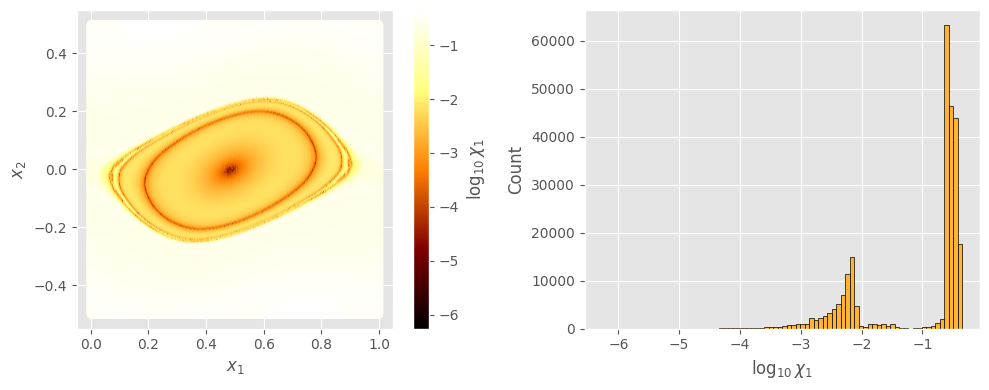

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

size = 12

axs[0].set_xlabel(r"$x_1$", fontsize=size)
axs[0].set_ylabel(r"$x_2$", fontsize=size)

sc1 = axs[0].scatter(
    init_coords[:, 0],
    init_coords[:, 1],
    marker="s",
    c=log_10_mcles,
    cmap="afmhot",
)
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_label(r"$\log_{10} \chi_1$")

axs[1].hist(log_10_mcles, bins=80, color=plt.cm.afmhot(0.6), edgecolor="black")
axs[1].set_xlabel(r"$\log_{10} \chi_1$", fontsize=size)
axs[1].set_ylabel("Count", fontsize=size)

plt.tight_layout()
plt.show()
